# Analysis of a single `trx.mat` file of a taxis experiment
v2.1 (modified 28.11.2025)

This version of the notebook works on anemotaxis and 'fictive' chemotaxis in a gradient.

* Generalizations of the direction of the gradient (e.g. -X for t7 of Jovanic Lab, -Y for t2)
* Adding bootstrapping to calculate the statistics of turn and head-cast better.  

There are two ways to use this file - 

1. As a standalone file, in which case, add a value of `single_path` in the cell (Cell [3] or Cell [4]) after the one where all the libraries are imported - where it says _Load single `trx.mat` file_. The value of `single_path` in the cell (Cell[3] or Cell [4]) should overwrite the blank value in the `single_path` variable below. Uncomment also, in this case, the last cell.

2. As part of a batch run (using the `batch_run_single_experiments.py` script), in which case, DON'T uncomment the cell where it says _Load single `trx.mat` file_. The `papermill` library of the `batch_run_single_experiments.py` script will take care of the parameter `single_path` in the next cell. It is intentionally hence left blank (`single_path = ""`). Check also, in this case, the last cell, to verify if it is commented.


In [10]:
# Parameters
single_path = ""

In [11]:
import sys
import os as os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
import core.data_loader as data_loader
import core.data_processor as data_processor
import viz.plot_data as plot_data
import utils.preprocessing as preprocessing

# Set matplotlib style
%matplotlib widget
%load_ext autoreload
%autoreload 2
plt.style.use('../anemotaxis.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
# Load single `trx.mat` file
# If you are using this notebook as a standalone notebook please uncomment and add here
single_path = '/Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/trx.mat'

In [13]:
trx_data = data_loader.load_single_trx_file(single_path, show_progress=True)


Processing file: /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/trx.mat
Number of larvae: 28


Processing larvae:   0%|          | 0/28 [00:00<?, ?it/s]

Processing larvae: 100% | 28/28 | Completed at: 2025-12-02 14:58:36 | Time taken: 00:00


In [14]:
# Get the parent directory of single_path and create analyses folder if it doesn't exist
# this is to save analysis results and figures if needed
parent_dir = os.path.dirname(single_path)
output_dir = os.path.join(parent_dir, 'analyses')
os.makedirs(output_dir, exist_ok=True)

### Ethogram
1. Raw ethogram
2. Filtering by duration (for anemotaxis, total duration is 600, usual minimum is 300s)
3. Filtering by removing larvae with excessive stop time (more than 0.5 of total time in stop)
4. Filtering by merging short stop sequences (less than 2s for cast, less than 3s for run)

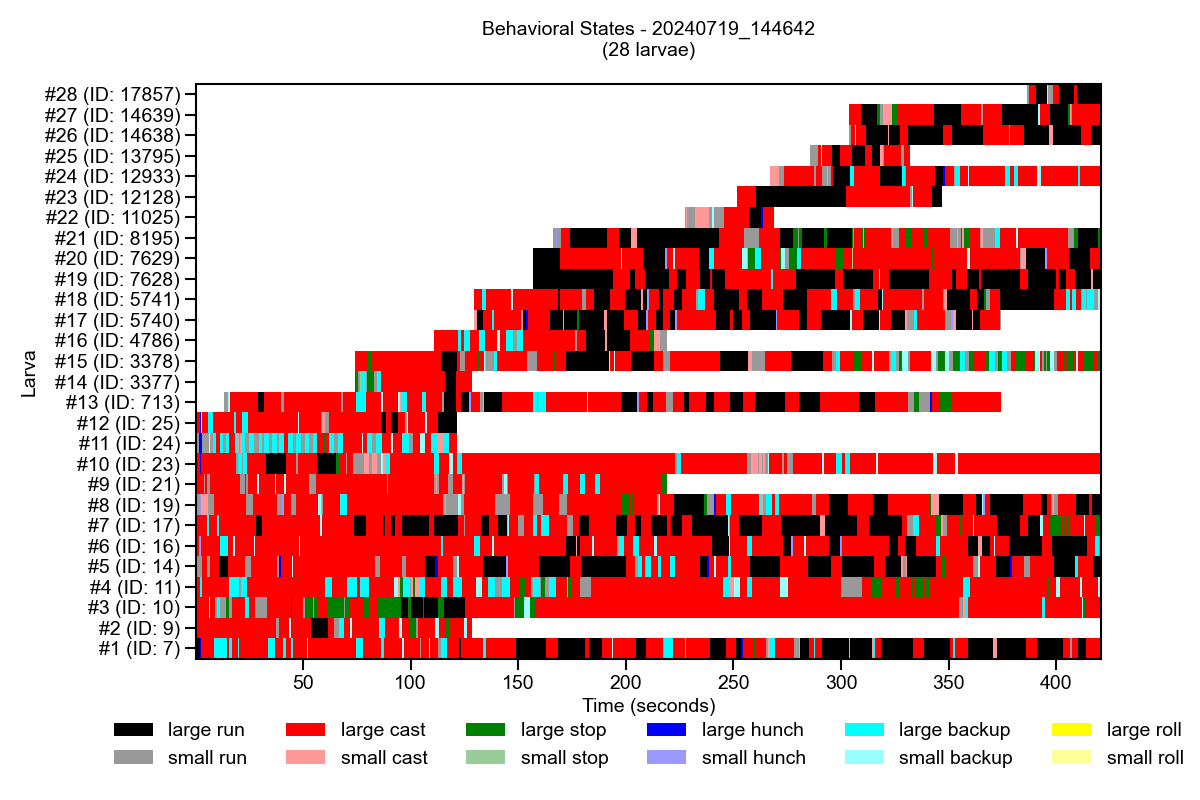

In [15]:
results_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_data)

Duration filtering results (threshold: 300.0s):
  - Removed 17 larvae with <300.0s total duration
  - 11 larvae remaining


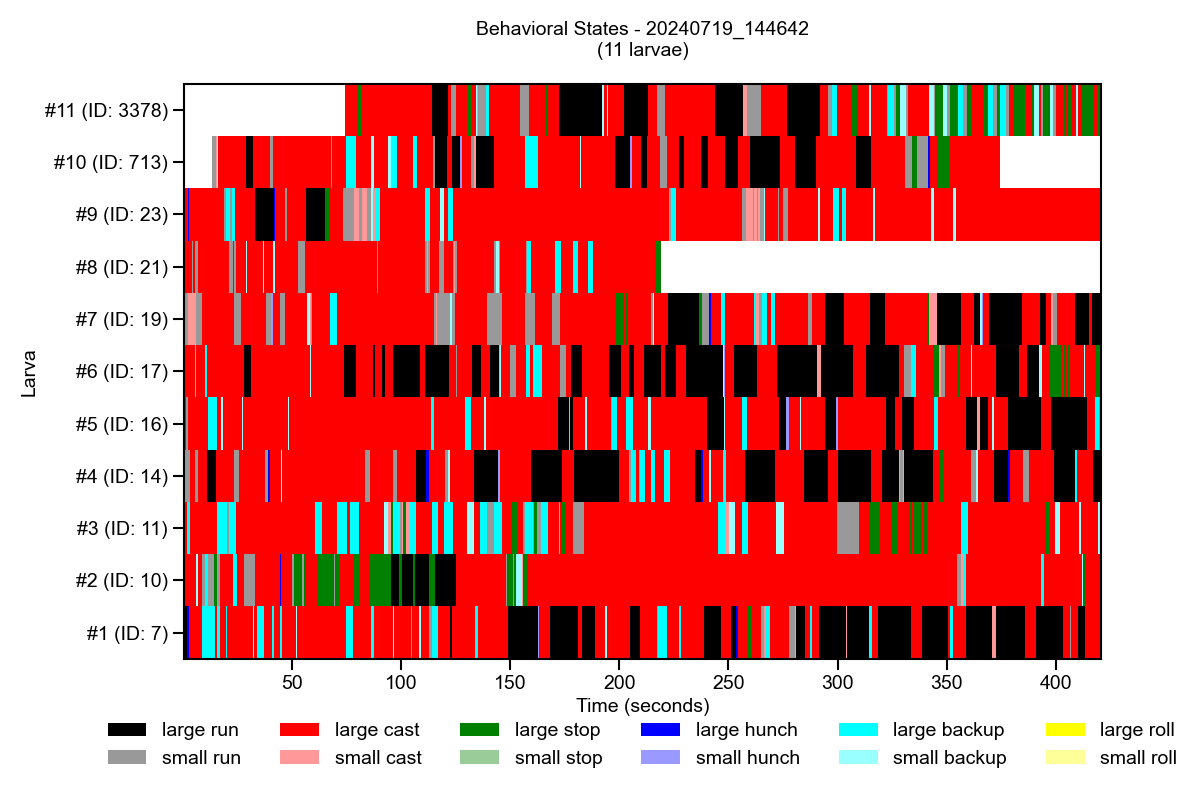

In [16]:
## Filtering by duration (for anemotaxis, total duration is 600, usual minimum is 300s)
min_total_duration= 300
trx_filtered_by_duration = preprocessing.filter_larvae_by_duration(trx_data, min_total_duration=min_total_duration)
results_filtered_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_filtered_by_duration)

Excess stop time filtering results (threshold: 50%):
  - Removed 0 larvae with >50% time in stop state
  - 11 larvae remaining


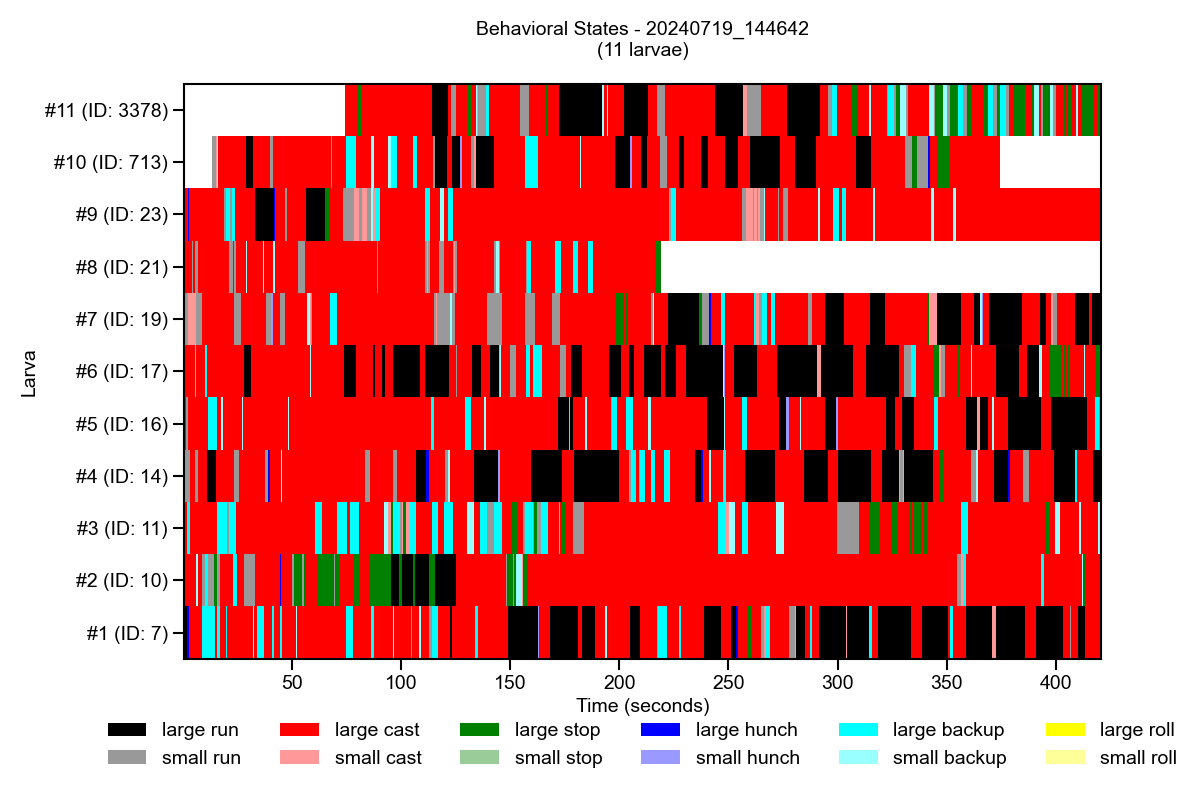

In [17]:
## Filtering by removing larvae with excessive stop time (more than 0.5 of total time in stop)
max_stop_percentage = 0.5
trx_filtered_by_removing_stops = preprocessing.filter_larvae_by_excess_stop_time(trx_filtered_by_duration, max_stop_percentage=max_stop_percentage)
results_filtered_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_filtered_by_removing_stops)

Merged 31 sequences with short stops:
  - 20 cast-stop-cast sequences
  - 9 run-stop-run sequences
  - 2 mixed sequences (run-stop-cast or cast-stop-run)
Total duration saved: 40.83 seconds


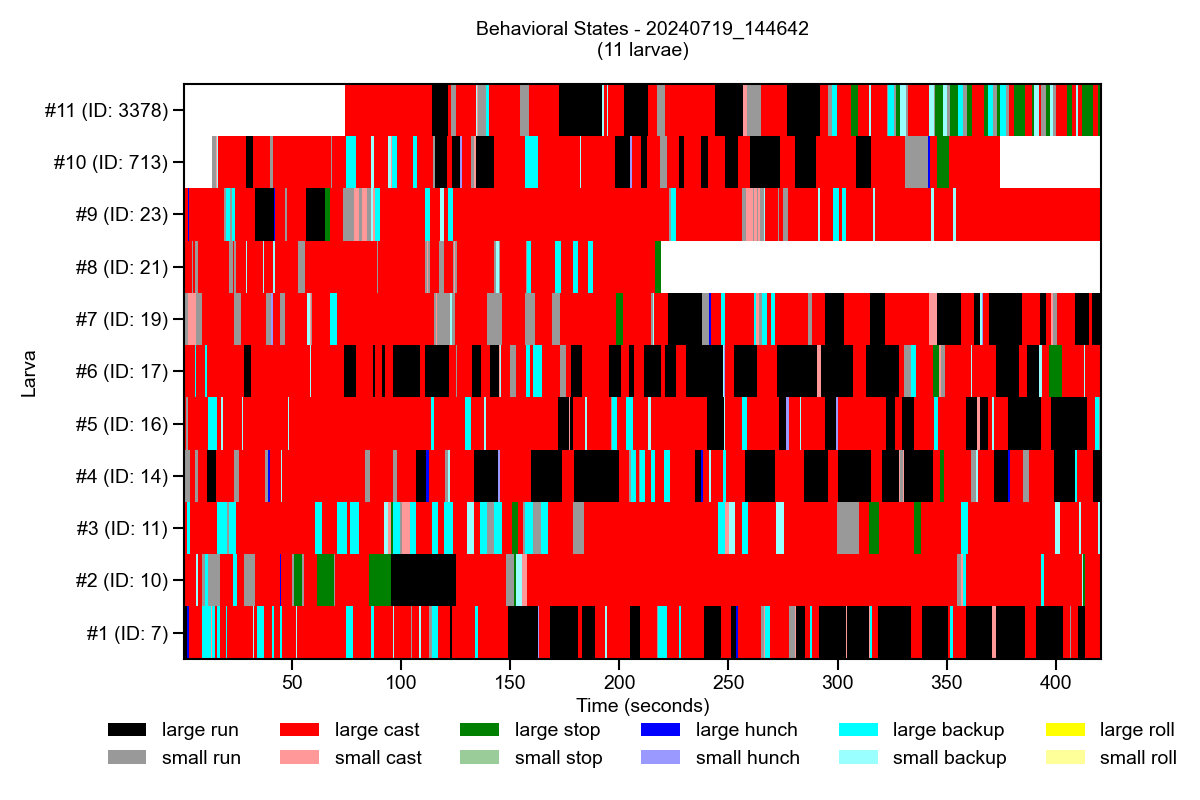

Behavior matrix figure saved to: /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/analyses/behavior_matrix_filtered.pdf


In [18]:
## Merging short stop sequences (less than 2s for cast, less than 3s for run)
trx_filtered_by_merging = preprocessing.merge_short_stop_sequences(trx_filtered_by_removing_stops, min_stop_duration_cast=2.0, min_stop_duration_run=3.0)
results_merged_behavior_matrix = plot_data.plot_global_behavior_matrix(trx_filtered_by_merging)
fig_behavior = plt.gcf()  # Get current figure
fig_behavior.savefig(os.path.join(output_dir, 'behavior_matrix_filtered.pdf'), 
                    bbox_inches='tight', 
                    dpi=300,
                    transparent=True,
                    facecolor='none')
print(f"Behavior matrix figure saved to: {os.path.join(output_dir, 'behavior_matrix_filtered.pdf')}")

### Event probabilites over orientation and time

In [19]:
# Analyze run probability by orientation and over time
run_prob_results = data_processor.analyze_run_probability_by_orientation(
    trx_filtered_by_merging, bin_width=10, sigma=2)
    
run_prob_time_results = data_processor.analyze_run_probability_over_time(
    trx_filtered_by_merging, window=60, step=20
)

# Analyze turn probability by orientation and over time
turn_prob_results = data_processor.analyze_turn_probability_by_orientation(
    trx_filtered_by_merging, bin_width=10, sigma=2, min_turn_amplitude=45, output_dir=output_dir)
turn_prob_time_results = data_processor.analyze_turn_probability_over_time(
    trx_filtered_by_merging, window=60, step=20, min_turn_amplitude=45
)

# Analyze backup probability by orientation and over time
backup_prob_results = data_processor.analyze_backup_probability_by_orientation(
    trx_filtered_by_merging, bin_width=10, sigma=2)
backup_prob_time_results = data_processor.analyze_backup_probability_over_time(
    trx_filtered_by_merging, window=60, step=20)



🎯 Cast & Turn Analysis Summary:
   Total casts processed: 275
   Total turns detected: 51
   Overall turn rate: 18.5%
   Min turn amplitude: 45°
   Orientation change stats:
     Mean: 26.5°
     Median: 10.3°
     Range: 0.1° - 178.3°
Detailed cast/turn info written to: /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/analyses/turn_probability_orientation_details.json


Saved to: /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/analyses


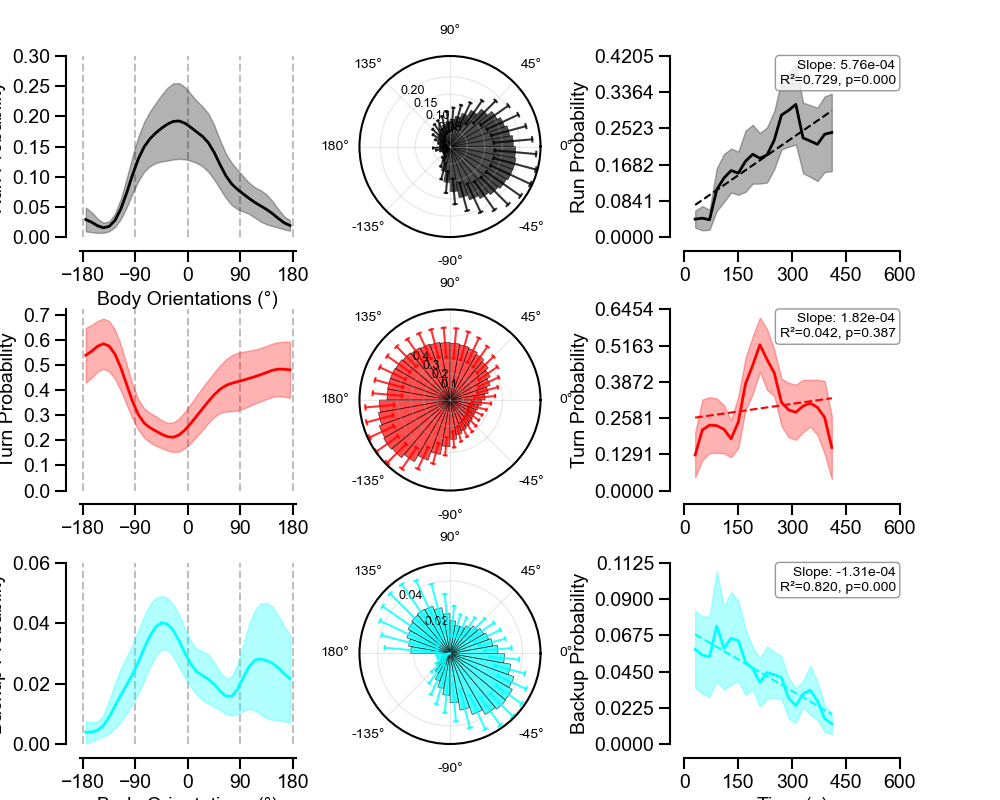

In [20]:
# Create figure with asymmetric spacing - polar plots closer to left
fig = plt.figure(figsize=(10, 8))
gs = GridSpec(3, 3, figure=fig, 
              left=0.08, right=0.90,
              top=0.93, bottom=0.07,
              wspace=0.4,               # Reduced overall spacing
              hspace=0.4,
              width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# Row 1: Run analysis
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1], projection='polar')
ax7 = fig.add_subplot(gs[0, 2])


plot_data.plot_orientation_histogram(run_prob_results, plot_type='run', ax = ax1)
plot_data.plot_orientation_histogram_polar(run_prob_results, plot_type='run', ax=ax2, bar_style=True, tick_fontsize=10)
ax2_pos = ax2.get_position()
ax2.set_position([ax2_pos.x0 - 0.04, ax2_pos.y0, ax2_pos.width, ax2_pos.height])


plot_data.plot_metric_over_time(run_prob_time_results, plot_type='run', ax=ax7, show_xlabel=False)


# Row 2: Turn analysis
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1], projection='polar')
ax8 = fig.add_subplot(gs[1, 2])

plot_data.plot_orientation_histogram(turn_prob_results, plot_type='turn', ax=ax3, ylabel='Turn Probability', show_xlabel=False)

plot_data.plot_orientation_histogram_polar(turn_prob_results, plot_type='turn', ax=ax4, bar_style=True, tick_fontsize=10)
ax4_pos = ax4.get_position()
ax4.set_position([ax4_pos.x0 - 0.04, ax4_pos.y0, ax4_pos.width, ax4_pos.height])

plot_data.plot_metric_over_time(turn_prob_time_results, plot_type='turn', ax=ax8, show_xlabel=False)

# Row 3: Backup analysis
ax5 = fig.add_subplot(gs[2, 0])
ax6 = fig.add_subplot(gs[2, 1], projection='polar')
ax9 = fig.add_subplot(gs[2, 2])


plot_data.plot_orientation_histogram(backup_prob_results, ax=ax5, ylabel='Backup Probability', color = 'cyan',show_xlabel=True)

plot_data.plot_orientation_histogram_polar(backup_prob_results, plot_type='backup', ax=ax6, bar_style=True, tick_fontsize=10)
ax6_pos = ax6.get_position()
ax6.set_position([ax6_pos.x0 - 0.04, ax6_pos.y0, ax6_pos.width, ax6_pos.height])
plot_data.plot_metric_over_time(backup_prob_time_results, plot_type='backup', ax=ax9, show_xlabel=True)

fig.savefig(os.path.join(output_dir, 'behavioral_analysis_summary.pdf'), 
            bbox_inches='tight', 
            dpi=300,
            transparent=True,      # Transparent background
            facecolor='none')      # No face color

print(f"Saved to: {output_dir}")

In [21]:

# Analyze turn amplitude by orientation and over time
turn_amp_results = data_processor.analyze_turn_amplitudes_by_orientation(
    trx_filtered_by_merging, bin_width=20, sigma=0.1, min_turn_amplitude=45
)
turn_amp_time_results = data_processor.analyze_turn_amplitudes_over_time(
    trx_filtered_by_merging, window=60, step=20, min_turn_amplitude=45
)


# Analyze run velocity by orientation and over time
velocity_results = data_processor.analyze_run_velocity_by_orientation(
    trx_filtered_by_merging, bin_width=15, sigma=2
)

velocity_results_pooled = data_processor.analyze_run_velocity_by_orientation_pooled(
    trx_filtered_by_merging, bin_width=15, sigma=2
)
velocity_time_results = data_processor.analyze_run_velocity_over_time(
    trx_filtered_by_merging, window=60, step=20
)

/Users/sharbat/Projects/anemotaxis/src/core/data_processor.py:978: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_hist = stats.sem(hist_arrays, axis=0, nan_policy='omit')
/Users/sharbat/Projects/anemotaxis/src/core/data_processor.py:1968: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_metric = stats.sem(metric_arrays, axis=0, nan_policy='omit')
/Users/sharbat/Projects/anemotaxis/src/core/data_processor.py:1120: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_hist = stats.sem(hist_

Combined velocity & amplitude figure saved to: /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/analyses/velocity_amplitude_analysis.pdf


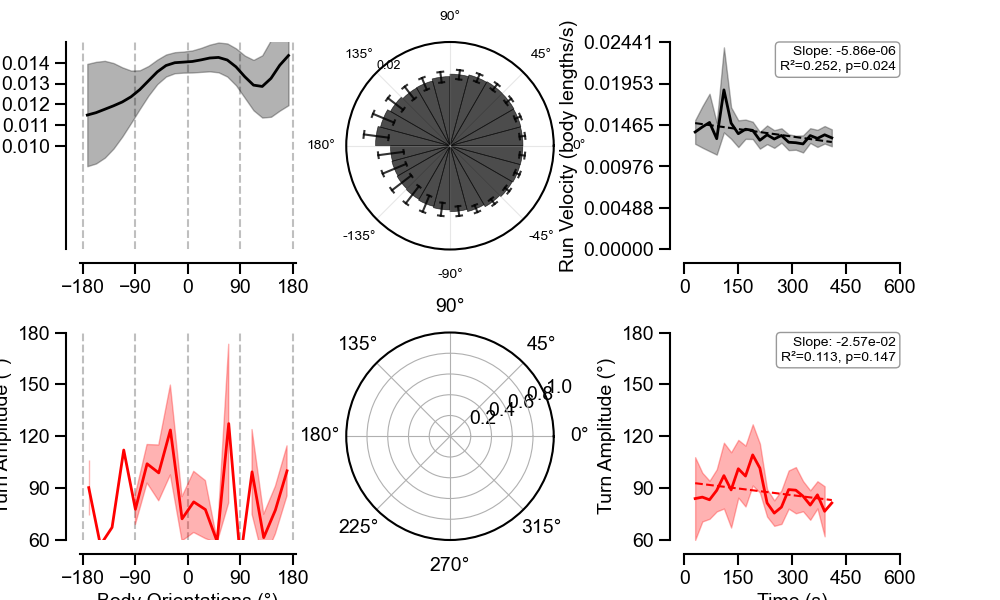

In [30]:
# Create combined figure with asymmetric spacing - polar plots closer to left
fig_combined = plt.figure(figsize=(10, 6))
gs_combined = GridSpec(2, 3, figure=fig_combined, 
                      left=0.08, right=0.90,
                      top=0.93, bottom=0.10,
                      wspace=0.4,               # Reduced overall spacing
                      hspace=0.4,
                      width_ratios=[0.6, 0.6, 0.6])  # Left wide, middle narrow, right wide

# Row 1: Run Velocity Analysis
ax_vel1 = fig_combined.add_subplot(gs_combined[0, 0])
ax_vel2 = fig_combined.add_subplot(gs_combined[0, 1], projection='polar')
ax_vel3 = fig_combined.add_subplot(gs_combined[0, 2])


# Linear plot
plot_data.plot_orientation_histogram(velocity_results_pooled, ax=ax_vel1, show_xlabel=False, ylabel='Run Velocity (body lengths/s)')
ax_vel1.set_ylim(0.005,0.015)
ax_vel1_y_ticks = [0.01, 0.011, 0.012, 0.013, 0.014]
ax_vel1.set_yticks(ax_vel1_y_ticks)

# Polar plot
plot_data.plot_orientation_histogram_polar(velocity_results_pooled, ax=ax_vel2, bar_style=True, tick_fontsize=10)
ax_vel2_pos = ax_vel2.get_position()
ax_vel2.set_position([ax_vel2_pos.x0 - 0.04, ax_vel2_pos.y0, ax_vel2_pos.width, ax_vel2_pos.height])

# Time series plot
plot_data.plot_metric_over_time(
    velocity_time_results, color = 'black',ylabel='Run Velocity (body lengths/s)',
    show_individuals=False, show_error=True, ax=ax_vel3, show_xlabel=False
)

# Row 2: Turn Amplitude Analysis
ax_amp1 = fig_combined.add_subplot(gs_combined[1, 0])
ax_amp2 = fig_combined.add_subplot(gs_combined[1, 1], projection='polar')
ax_amp3 = fig_combined.add_subplot(gs_combined[1, 2])

# Set minimum amplitude
min_amp = 60

# Check if we have ANY valid (non-NaN) data
if turn_amp_results and 'mean_hist' in turn_amp_results:
    mean_hist = np.array(turn_amp_results['mean_hist'])
    has_data = np.any(~np.isnan(mean_hist))
else:
    has_data = False


# Linear plot
plot_data.plot_orientation_histogram(turn_amp_results, ax=ax_amp1, ylabel='Turn Amplitude (°)', 
                                     show_xlabel=True, min_amplitude=min_amp, plot_type='turn_amplitude')

# Polar plot - only if there's valid data
# plot_data.plot_orientation_histogram_polar(turn_amp_results, ax=ax_amp2, bar_style=True, 
#                                     tick_fontsize=10, min_amplitude=min_amp, plot_type='turn_amplitude')
ax_amp2_pos = ax_amp2.get_position()
ax_amp2.set_position([ax_amp2_pos.x0 - 0.04, ax_amp2_pos.y0, ax_amp2_pos.width, ax_amp2_pos.height])

# Time series plot
plot_data.plot_metric_over_time(
    turn_amp_time_results, plot_type='turn_amplitude', 
    show_individuals=False, show_error=True, ax=ax_amp3, show_xlabel=True,
    min_amplitude=min_amp
)


# Save the combined figure
fig_combined.savefig(os.path.join(output_dir, 'velocity_amplitude_analysis.pdf'), 
                    bbox_inches='tight', 
                    dpi=300,
                    transparent=True,
                    facecolor='none')
print(f"Combined velocity & amplitude figure saved to: {os.path.join(output_dir, 'velocity_amplitude_analysis.pdf')}")

plt.show()

🎯 Head Cast Detection Summary (with Turn Detection)
Larva  7: 37 cast periods ( 6 turns),  51 head casts ( 7 perpendicular:  3 towards [42.9%],  4 away [57.1%])
Larva 10: 13 cast periods ( 1 turns),  40 head casts (16 perpendicular:  5 towards [31.2%], 11 away [68.8%])
Larva 11: 23 cast periods ( 2 turns),  41 head casts ( 9 perpendicular:  5 towards [55.6%],  4 away [44.4%])
Larva 14: 30 cast periods (10 turns),  36 head casts ( 5 perpendicular:  3 towards [60.0%],  2 away [40.0%])
Larva 16: 27 cast periods ( 5 turns),  54 head casts (16 perpendicular:  7 towards [43.8%],  9 away [56.2%])
Larva 17: 34 cast periods ( 8 turns),  40 head casts ( 9 perpendicular:  4 towards [44.4%],  5 away [55.6%])
Larva 19: 25 cast periods ( 5 turns),  31 head casts (13 perpendicular:  7 towards [53.8%],  6 away [46.2%])
Larva 21: 18 cast periods ( 1 turns),  18 head casts ( 7 perpendicular:  4 towards [57.1%],  3 away [42.9%])
Larva 23: 21 cast periods ( 4 turns),  54 head casts (15 perpendicular:  9 t

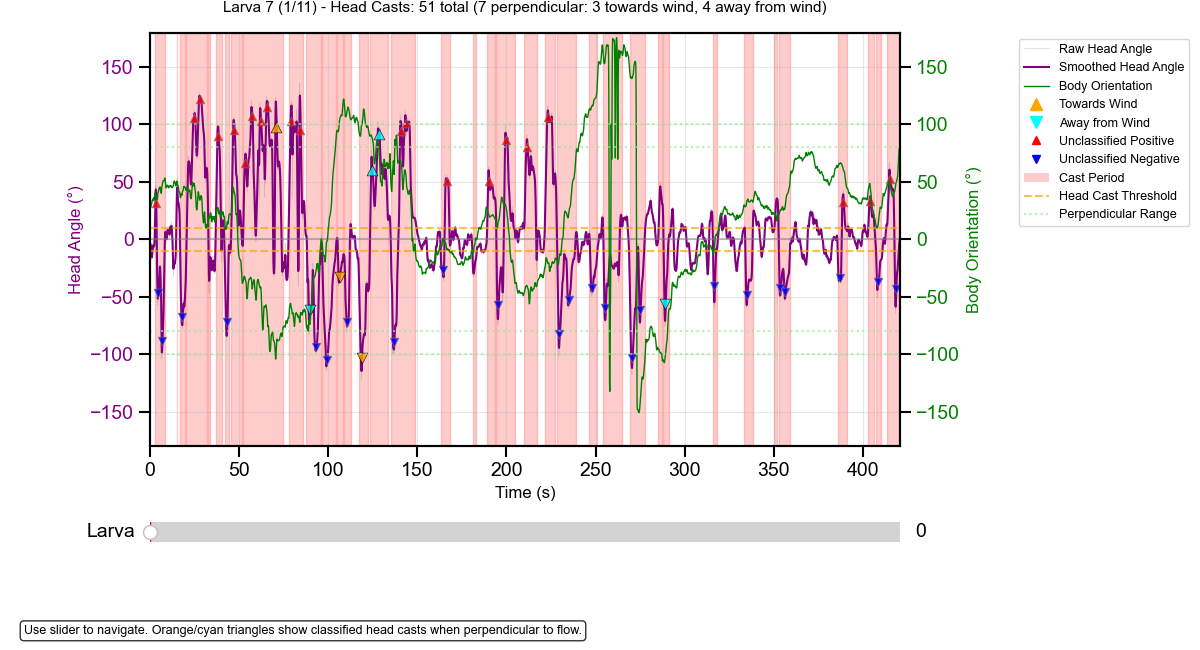

In [32]:
# Detect head casts with new method
cast_events_data = data_processor.detect_head_casts_in_casts(
    trx_filtered_by_merging,
    peak_threshold=10.0,
    peak_prominence=10.0,
    smooth_sigma=10,
    print_summary=True
)

# Plot with individual subplots
fig = plot_data.plot_cast_detection_results(
    trx_filtered_by_merging,
    cast_events_data,
    figsize=(12,6.5),
    save_path=os.path.join(output_dir, 'cast_detection_all_larvae.pdf'),
    time_range=None  # Full time range
)


🎯 First Head Cast Bias Analysis
Larva  7:  5 first perpendicular head casts ( 2 towards [40.0%],  3 away [60.0%])
Larva 10:  8 first perpendicular head casts ( 2 towards [25.0%],  6 away [75.0%])
Larva 14:  3 first perpendicular head casts ( 2 towards [66.7%],  1 away [33.3%])
Larva 16:  7 first perpendicular head casts ( 3 towards [42.9%],  4 away [57.1%])
Larva 17:  8 first perpendicular head casts ( 4 towards [50.0%],  4 away [50.0%])
Larva 19: 10 first perpendicular head casts ( 5 towards [50.0%],  5 away [50.0%])
Larva 21:  3 first perpendicular head casts ( 2 towards [66.7%],  1 away [33.3%])
Larva 23:  4 first perpendicular head casts ( 2 towards [50.0%],  2 away [50.0%])
Larva 713:  3 first perpendicular head casts ( 1 towards [33.3%],  2 away [66.7%])
Larva 3378:  1 first perpendicular head casts ( 0 towards [0.0%],  1 away [100.0%])

📊 Statistical Tests (n=9 larvae with ≥2 events):
   Wilcoxon signed-rank test: p=0.5625
   ✗ No significant bias detected (Wilcoxon p ≥ 0.05)
-

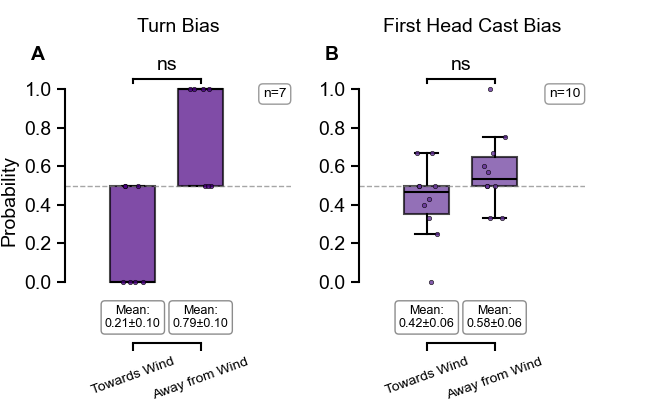

In [34]:
# Analyze first head cast bias
bias_results_first = data_processor.analyze_head_cast_bias(
    cast_events_data, 
    analysis_type='first'
)

# NEW: Analyze turn bias from perpendicular orientations
bias_results_turn = data_processor.analyze_head_cast_bias(
    cast_events_data, 
    analysis_type='turn'
)

# Create 1x2 figure layout for first head cast bias and turn bias only
fig_bias = plt.figure(figsize=(6.5, 4))  # Reduced width for 2 plots
gs_bias = GridSpec(1, 2, figure=fig_bias, 
                   left=0.10, right=0.90,  # Adjusted margins
                   top=0.85, bottom=0.15,
                   wspace=0.3)  # Spacing for 2 plots

# Plot turn bias (first panel)
ax_bias1 = fig_bias.add_subplot(gs_bias[0, 0])
plot_data.plot_head_cast_bias_perpendicular(
    bias_results_turn,
    ax=ax_bias1,
    title='Turn Bias',
    plot_type='violn'
)
ax_bias1.text(-0.15, 1.05, 'A', transform=ax_bias1.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')

# Plot first head cast bias (second panel)
ax_bias2 = fig_bias.add_subplot(gs_bias[0, 1])
plot_data.plot_head_cast_bias_perpendicular(
    bias_results_first,
    ax=ax_bias2,
    title='First Head Cast Bias',
    plot_type='violn'
)
ax_bias2.text(-0.15, 1.05, 'B', transform=ax_bias2.transAxes, 
              fontsize=14, fontweight='bold', va='top', ha='left')
ax_bias2.set_ylabel('')  # Remove y-label for second plot

# Save the combined figure
fig_bias.savefig(os.path.join(output_dir, 'head_cast_bias_first_and_turn.pdf'), 
                bbox_inches='tight', 
                dpi=300,
                transparent=True,
                facecolor='none')
print(f"First head cast bias and turn bias figure saved to: {os.path.join(output_dir, 'head_cast_bias_first_and_turn.pdf')}")

plt.show()


🎯 Head Casts by Turn Success Analysis (Min turn: 45°)
Larva  7: 37 casts ( 6 turns, 31 non-turns, 16.2%)
           Head casts: 10 in successful turns, 41 in unsuccessful, 51 total
Larva 10: 13 casts ( 1 turns, 12 non-turns,  7.7%)
           Head casts: 25 in successful turns, 15 in unsuccessful, 40 total
Larva 11: 23 casts ( 2 turns, 21 non-turns,  8.7%)
           Head casts: 15 in successful turns, 26 in unsuccessful, 41 total
Larva 14: 30 casts (10 turns, 20 non-turns, 33.3%)
           Head casts: 10 in successful turns, 26 in unsuccessful, 36 total
Larva 16: 27 casts ( 5 turns, 22 non-turns, 18.5%)
           Head casts: 15 in successful turns, 39 in unsuccessful, 54 total
Larva 17: 34 casts ( 8 turns, 26 non-turns, 23.5%)
           Head casts: 18 in successful turns, 22 in unsuccessful, 40 total
Larva 19: 25 casts ( 5 turns, 20 non-turns, 20.0%)
           Head casts: 12 in successful turns, 19 in unsuccessful, 31 total
Larva 21: 18 casts ( 1 turns, 17 non-turns,  5.6%)
     

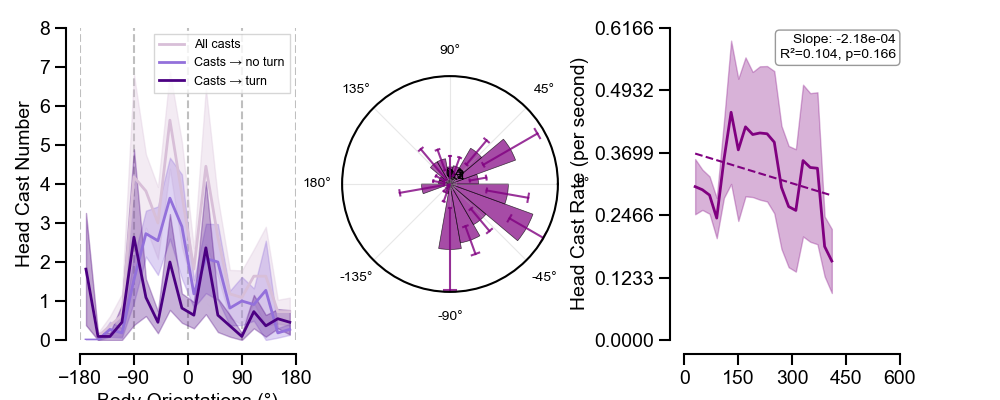

In [35]:
# Analyze head casts by cast start orientation - separated by turn success
head_cast_orientation_results = data_processor.analyze_head_casts_by_orientation(
    trx_filtered_by_merging, 
    bin_width=20, 
    peak_threshold=10.0,
    peak_prominence=10.0,
    smooth_sigma=10,
    large_casts_only=True,
    separate_by_turn_success=True,  # NEW PARAMETER
    min_turn_amplitude=45
)

# Create combined figure for head cast analysis
fig_head_casts = plt.figure(figsize=(10, 4))
gs_head_casts = GridSpec(1, 3, figure=fig_head_casts, 
                        left=0.08, right=0.90,
                        top=0.93, bottom=0.15,
                        wspace=0.4,               
                        width_ratios=[0.6, 0.6, 0.6])

# Row 1: Head Cast Analysis
ax_hc1 = fig_head_casts.add_subplot(gs_head_casts[0, 0])
ax_hc2 = fig_head_casts.add_subplot(gs_head_casts[0, 1], projection='polar')
ax_hc3 = fig_head_casts.add_subplot(gs_head_casts[0, 2])

# Linear plot with turn success separation
plot_data.plot_head_cast_orientation_by_turn_success(
    head_cast_orientation_results,
    ax=ax_hc1, 
    show_xlabel=True, 
    ylabel='Head Cast Number',
    ylim=[0,8]
)

# Polar plot (use all casts for polar representation)
plot_data.plot_orientation_histogram_polar(head_cast_orientation_results, 
                                        ax=ax_hc2, 
                                        plot_type='head_cast',
                                        bar_style=True, 
                                        tick_fontsize=10)
ax_hc2_pos = ax_hc2.get_position()
ax_hc2.set_position([ax_hc2_pos.x0 - 0.04, ax_hc2_pos.y0, ax_hc2_pos.width, ax_hc2_pos.height])

# Time series plot (analyze head casts over time - this uses a different function)
head_cast_time_results = data_processor.analyze_head_casts_over_time(
    trx_filtered_by_merging, 
    window=60, 
    step=20,
    peak_threshold=20.0, 
    peak_prominence=3.0,
    smooth_sigma=4.0,
    large_casts_only=True
)

plot_data.plot_metric_over_time(
    head_cast_time_results, plot_type='head_cast', ylabel='Head Cast Rate (per second)',
    show_individuals=False, show_error=True, ax=ax_hc3, show_xlabel=False
)

# Save the head cast analysis figure
fig_head_casts.savefig(os.path.join(output_dir, 'head_cast_analysis_by_turn_success.pdf'), 
                      bbox_inches='tight', 
                      dpi=300,
                      transparent=True,
                      facecolor='none')
print(f"Head cast analysis figure saved to: {os.path.join(output_dir, 'head_cast_analysis_by_turn_success.pdf')}")

plt.show()

Figure saved to /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/analyses/ni_over_time.pdf


/Users/sharbat/Projects/anemotaxis/src/core/data_processor.py:3508: RuntimeWarning: Mean of empty slice
  mean_NI_x = np.nanmean(NI_x_mat, axis=0)
/Users/sharbat/Projects/anemotaxis/src/core/data_processor.py:3509: RuntimeWarning: Mean of empty slice
  mean_NI_y = np.nanmean(NI_y_mat, axis=0)
/Users/sharbat/Projects/anemotaxis/src/core/data_processor.py:3510: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_NI_x = stats.sem(NI_x_mat, axis=0, nan_policy='omit')
/Users/sharbat/Projects/anemotaxis/src/core/data_processor.py:3511: SmallSampleWarning: After omitting NaNs, one or more axis-slices of one or more sample arguments is too small; corresponding elements of returned arrays will be NaN. See documentation for sample size requirements.
  se_NI_y = stats.sem(NI_y_mat, axis=0, nan_policy='omit')


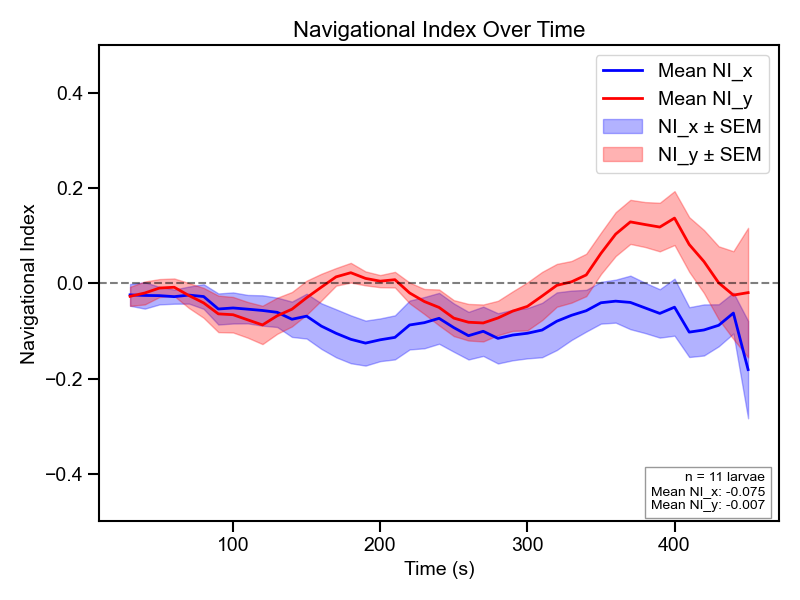

/Users/sharbat/Projects/anemotaxis/src/viz/plot_data.py:2646: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=figsize)


Figure saved to /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/analyses/ni_boxplot.pdf


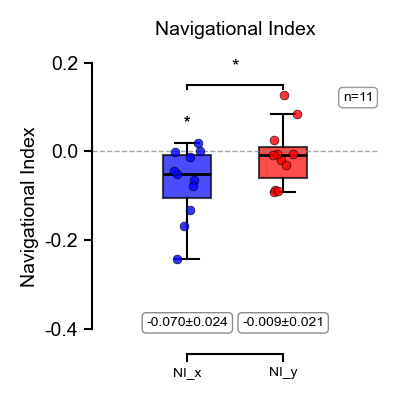


=== NAVIGATIONAL INDEX ANALYSIS ===
Number of larvae: 11
Mean NI_x: -0.070 (p=0.0161, *)
Mean NI_y: -0.009 (p=0.6820, ns)
Paired comparison NI_x vs NI_y: p=0.0403
RESULT: NI_x and NI_y are significantly different from each other


In [36]:
# 1. Analyze NI over time
ni_time_results = data_processor.analyze_navigational_index_over_time(
    trx_filtered_by_merging, window=60, step=10, t_max=600
)

# 2. Analyze single NI values per larva
ni_single_results = data_processor.analyze_navigational_index_single_values(
    trx_filtered_by_merging, window=60, step=10, t_max=600
)

# 3. Plot time series
fig_time = plot_data.plot_navigational_index_over_time(
    ni_time_results,
    save_path=os.path.join(output_dir, 'ni_over_time.pdf')
)

# 4. Plot box plots
fig_box = plot_data.plot_navigational_index_boxplot(
    ni_single_results,
    save_path=os.path.join(output_dir, 'ni_boxplot.pdf')
)


In [37]:
# In analyze_single_anemotaxis.ipynb, replace the save_analysis_results call with:
saved_file = data_loader.save_analysis_results(
    output_dir,
    single_path,
    trx_filtered_by_merging,
    
    # Orientation-based analyses (consistent naming)
    run_prob_results=run_prob_results,
    turn_prob_results=turn_prob_results,
    turn_amp_results=turn_amp_results,
    backup_prob_results=backup_prob_results,
    velocity_results=velocity_results,
    
    # Time-based analyses (consistent naming)
    run_prob_time_results=run_prob_time_results,
    turn_prob_time_results=turn_prob_time_results,
    turn_amp_time_results=turn_amp_time_results,
    backup_prob_time_results=backup_prob_time_results,
    velocity_time_results=velocity_time_results,
    
    # Head cast analyses
    # cast_events_data=cast_events_data,
    bias_results_first=bias_results_first,
    # bias_results_last=bias_results_last,
    # bias_results_all=bias_results_all,
    bias_results_turn=bias_results_turn,
    head_cast_orientation_results=head_cast_orientation_results,
    head_cast_time_results=head_cast_time_results,

    # NI results
    ni_time_results=ni_time_results,
    ni_single_results=ni_single_results
)

💾 Saving run_prob_results...
💾 Saving turn_prob_results...
💾 Saving turn_amp_results...
💾 Saving backup_prob_results...
💾 Saving velocity_results...
💾 Saving run_prob_time_results...
💾 Saving turn_prob_time_results...
💾 Saving turn_amp_time_results...
💾 Saving backup_prob_time_results...
💾 Saving velocity_time_results...
💾 Saving bias_results_first...
💾 Saving bias_results_turn...
💾 Saving head_cast_orientation_results...
💾 Saving head_cast_time_results...
💾 Saving ni_time_results...
💾 Saving ni_single_results...
📁 Analysis results saved to: /Users/sharbat/Projects/anemotaxis/data/t7/W1118@20XUAS_CsChrimsom_mVenus/ch_95grad_2s1x420s0s#p_5gradient2_2s1x420s0s#n#n/20240719_144642/analyses/analysis_results_20251202_150332.h5


Usually, the following code saves a PDF version of this Jupyter Notebook. To use it, one has to uncomment the following, save the notebook (with ^/ctrl + S or ⌘/cmd + S) and then run it.

Otherwise, if using the notebook as part of the `batch_run_single_experiments.py` script, leave it commented out.

In [38]:
# # Export notebook as PDF
# from nbconvert import PDFExporter
# from IPython.display import Javascript, display
# import time

# # First, save the notebook automatically
# print("💾 Saving notebook...")
# display(Javascript('IPython.notebook.save_checkpoint();'))
# time.sleep(2)  # Wait for save to complete

# try:
#     # Get the current notebook path
#     notebook_path = "/Users/sharbat/Projects/anemotaxis/scripts/analyze_single_anemotaxis.ipynb"
#     pdf_output_path = os.path.join(output_dir, 'analyze_single_anemotaxis.pdf')
    
#     # Export using nbconvert directly
#     exporter = PDFExporter()
#     (body, resources) = exporter.from_filename(notebook_path)
    
#     with open(pdf_output_path, 'wb') as f:
#         f.write(body)
    
#     print(f"✅ Notebook PDF saved to: {pdf_output_path}")
    
# except Exception as e:
#     print(f"❌ PDF export failed: {e}")
#     print("💡 Alternative: Use Jupyter's File menu > Download as > PDF via LaTeX")